# Flux calibration

Our science goal is to monitor the flux density variations of methanol masers.  What we actually measure is antenna temperature in Kelvins.  What we want is flux density in Jy.

We use known flux calibrators - continuum point sources that are well characterised and stable - to give us a conversion factor between antenna temperature and flux density.  This is known as the Point Source Sensitivity (PSS). The inverse of this number is the gain $G$.  

The relation between the flux density $S$ of an unresolved source and the antenna temperature $T_A$ due to that source is given by 
$$ S = \frac{2kT_A}{eA}$$
    
where $k$ is Boltzmann's constant, $e$ is the apperture efficiency and $A$ is the geometric area of the aperture.

We define the gain as
$$G= \frac{T_A}{S} $$

A common measure of antenna performance is the system equivalent flux density (SEFD), which is the flux density that a source would have to have in order to double the measured system temperature.
$$SEFD = \frac {T_{sys}}{G}$$

The 26-m has slight variations in pointing, so in order to make sure we accurately measure the peak flux of the source, we do a series of drift scans at the expected north and south half-power points, as well as the centre.  Basically we park the telescope at a coordinate just ahead of where the source currently is in the sky, and wait for earth's rotation to carry the telescope beam across the source.  The advantage of this is that you don't have to worry about whether your telescope can drive  at a consistent speed across the source.  The 26-m tracks perfectly at sidereal rate, but is not very good at higher speeds.  Other telescopes may choose to use on-the-fly scans, where they sample the power at a high rate while slewing across the source.


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as pyfits
import os
from scipy import stats
#display figures inline 
%matplotlib inline  

Select an observation to work on and open the fits file

In [17]:
fitsfile = 'data/continuum_drift_scans/2004d142_18h49m34s_Cont_sharmila_VIRGO_A.fits'
#fitsfile = 'data/continuum_drift_scans/2004d143_15h04m53s_Cont_sharmila_HYDRA_A.fits'
hdulist = pyfits.open(fitsfile) 

# Examine the fits file

In [18]:
hdulist.info()

Filename: data/continuum_drift_scans/2004d142_18h49m34s_Cont_sharmila_VIRGO_A.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      25   ()              
1    04.5S       BinTableHDU     60   1R x 13C     [1D, 1D, 1D, 8A, 1D, 8A, 1D, 27A, 1D, 1D, 28A, 1D, 1D]   
2    Drift       BinTableHDU     94   100R x 23C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
3    Drift       BinTableHDU     90   1540R x 23C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
4    Drift       BinTableHDU     90   1540R x 23C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
5    Drift       BinTableHDU     90   1540R x 23C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   


There are several data tables in this file.   

The first  header data unit (HDU) contains information on the  observation.  

The second one has information on the 4.5 cm feed system and was intended to have calibration data.  This data is not necessarily up to date, so we generally disregard it.

The third unit has the noise diode firing, used to convert from raw counts to Kelvins.

The next three binary tables are the drift scans themselves, starting at the north offset position.


In [19]:
hdulist[0].header

SIMPLE  =                    T                                                  
BITPIX  =                    8                                                  
NAXIS   =                    0                                                  
EXTEND  =                    T                                                  
DATE    = '2004-05-21T18:49:34' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
COMMENT information about the object, from scheduler task                       
OBJECT  = 'VIRGO A '           / Name of object                                 
LONGITUD=     187.705916666667 / Longitude of object                            
LATITUDE=     12.3911111111111 / Latitude of object                             
EQUINOX = '2000.0  '                                                            
COMMENT information about the scan, from scheduler task                         
OBSERVER= 'S Goedhart'         / Principal Investigator                         
OBSLOCAL= 'sharmila'        

A note on the field called 'upgrade' - during this time the dish surface was being replaced with solid panels.  Sometimes panels were missing, or mis-aligned.  Depending on which ring was being worked on, this could have a significant impact on the aperture efficiency and the point source sensitivity.

Extract the data

In [20]:
noise_cal = hdulist[2]
drift1 = hdulist[3]
drift2 = hdulist[4]
drift3 = hdulist[5]

In [21]:
drift1.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  184 / width of table in bytes                        
NAXIS2  =                 1540 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   23 / number of fields in each row                   
EXTNAME = 'Drift   '           / name of this binary table extension            
FRONTEND= '04.5S   '           / Frontend ID                                    
CENTFREQ=             6668.518 / [MHz] Backend centre frequency                 
BANDWDTH=                  16. / [MHz] Bandwidth of backend                     
TCAL1   =                 14

Most of the fields are actually just the position in different formats. We are interested in the signal 'Count1' and 'Count2'.  

In [22]:
noise_cal.columns

ColDefs(
    name = 'MJD'; format = '1D'; unit = 'days'
    name = 'Count1'; format = '1D'; unit = 'Hz'
    name = 'Count2'; format = '1D'; unit = 'Hz'
    name = 'Hour_Angle'; format = '1D'; unit = 'deg'
    name = 'Declination'; format = '1D'; unit = 'deg'
    name = 'Azimuth'; format = '1D'; unit = 'deg'
    name = 'Elevation'; format = '1D'; unit = 'deg'
    name = 'RA_Apparent'; format = '1D'; unit = 'deg'
    name = 'Dec_Apparent'; format = '1D'; unit = 'deg'
    name = 'RA_Mean'; format = '1D'; unit = 'deg'
    name = 'Dec_Mean'; format = '1D'; unit = 'deg'
    name = 'RA_B1950'; format = '1D'; unit = 'deg'
    name = 'Dec_B1950'; format = '1D'; unit = 'deg'
    name = 'RA_J2000'; format = '1D'; unit = 'deg'
    name = 'Dec_J2000'; format = '1D'; unit = 'deg'
    name = 'Galactic_Long'; format = '1D'; unit = 'deg'
    name = 'Galactic_Lat'; format = '1D'; unit = 'deg'
    name = 'Ecliptic_Long'; format = '1D'; unit = 'deg'
    name = 'Ecliptic_Lat'; format = '1D'; unit = 'deg'
 

# Noise calibration

A noise diode, when activated, generates a consistent signal corresponding to a temperature $T_{cal}$(K). We use this signal to calibrate the system gain, enabling us convert from raw counts (or voltage, as the case may be) to Kelvins.  The frequency and duration of noise diode firings depends entirely on the gain stability of the system.  One does not want to fire the noise diode during observations, because it increases the system noise when it is on, affecting sensitivity.  Most systems will have a design requirement that the gain remain stable, or behave in a linear manner, over the duration of a typical scan. Some causes of gain variation could be temperature variations, or the bending RF cables as the telescope moves around.

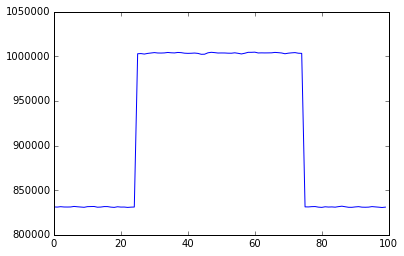

In [23]:
plt.plot(noise_cal.data['Count1'])
#plt.axis('tight')

So what we want to do is measure the amplitude of the jump between the system level counts and the noise diode firing. We're going to detect at which index the jumps occur, and we can either fit a linear function to the two sections, or simply take the mean.  In most cases, the counts should remain very stable for the duration of the noise diode calibration cycle. The noise diode values are give in the header of the file as TCAL1 and TCAL2 for the two channels (which correspond to left and right circular).

The diff function will calculate the difference between adjacent values in an array. This is a quick way to find where there are abrupt changes in a data-series.

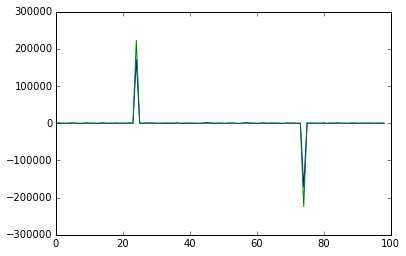

In [24]:
jumps1 = np.diff(noise_cal.data['Count1'])
jumps2 = np.diff(noise_cal.data['Count2'])
plt.plot(jumps1) 
plt.plot(jumps2) 

The spike corresponds to when the noise diode turns on.  The drop corresponds to when the noise diode turns off.

Counts per Kelvin for channel 1 is 12139.79 +- 89.41


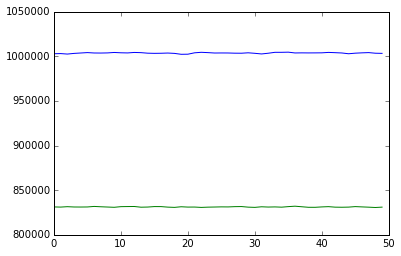

In [25]:
#find the array indices at which the noise diode turns on and off for channel 1
nd_on_pos1 = np.argmax(jumps1)+1
nd_off_pos1 = np.argmin(jumps1)+1
#there are two segments where the noise diode is off.  We concatenate these two segments
nd_off_count1 = np.concatenate((noise_cal.data['Count1'][:nd_on_pos1], noise_cal.data['Count1'][nd_off_pos1:]))
nd_off_mean1 = np.mean(nd_off_count1)
nd_off_sem1 = stats.sem(nd_off_count1)

nd_on_count1 = noise_cal.data['Count1'][nd_on_pos1:nd_off_pos1]
nd_on_mean1 = np.mean(nd_on_count1)
nd_on_sem1 = stats.sem(nd_on_count1)
err_1 = np.sqrt(nd_on_sem1**2 + nd_off_sem1**2)

#verify that our selection criteria were correct
plt.plot(nd_on_count1)
plt.plot(nd_off_count1)
#counts per Kelvin
count_K1 = (nd_on_mean1 - nd_off_mean1)/noise_cal.header['TCAL1']
print('Counts per Kelvin for channel 1 is %.2f +- %.2f'%(count_K1, err_1))

Counts per Kelvin for channel 2 is 10631.11 +- 84.79


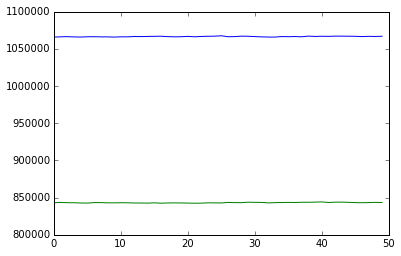

In [26]:
#repeat for second polarisation
#find the array indices at which the noise diode turns on and off for channel 2
nd_on_pos2 = np.argmax(jumps2)+1
nd_off_pos2 = np.argmin(jumps2)+1
#there are two segments where the noise diode is off.  We concatenate these two segments
nd_off_count2 = np.concatenate((noise_cal.data['Count2'][:nd_on_pos2], noise_cal.data['Count2'][nd_off_pos2:]))
nd_off_mean2 = np.mean(nd_off_count2)
nd_off_sem2 = stats.sem(nd_off_count2)

nd_on_count2 = noise_cal.data['Count2'][nd_on_pos2:nd_off_pos2]
nd_on_mean2 = np.mean(nd_on_count2)
nd_on_sem2 = stats.sem(nd_on_count2)
err_2 = np.sqrt(nd_on_sem2**2 + nd_off_sem2**2)

#verify that our selection criteria were correct
plt.plot(nd_on_count2)
plt.plot(nd_off_count2)
#counts per Kelvin
count_K2 = (nd_on_mean2 - nd_off_mean2)/noise_cal.header['TCAL2']
print('Counts per Kelvin for channel 2 is %.2f +- %.2f'%(count_K2, err_2))

This was just a demonstration of what is being done by the online system.  The same conversion (labelled HZperK) is already in the header.

In [27]:
noise_cal.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  184 / width of table in bytes                        
NAXIS2  =                  100 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   23 / number of fields in each row                   
EXTNAME = 'Drift   '           / name of this binary table extension            
FRONTEND= '04.5S   '           / Frontend ID                                    
CENTFREQ=             6668.518 / [MHz] Backend centre frequency                 
BANDWDTH=                  16. / [MHz] Bandwidth of backend                     
TCAL1   =                 14

In [28]:
count_K1 = noise_cal.header['HZPERK1']
count_K2 = noise_cal.header['HZPERK2']

# Measure the peak antenna temperature

## Load and plot data

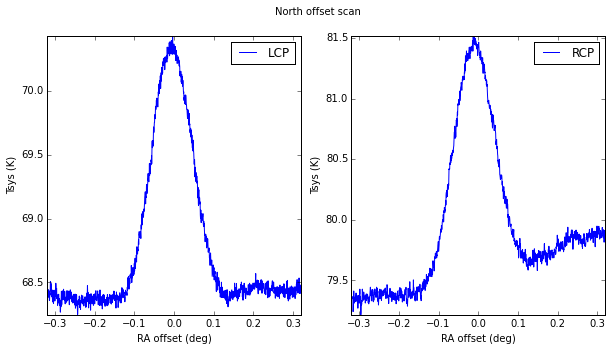

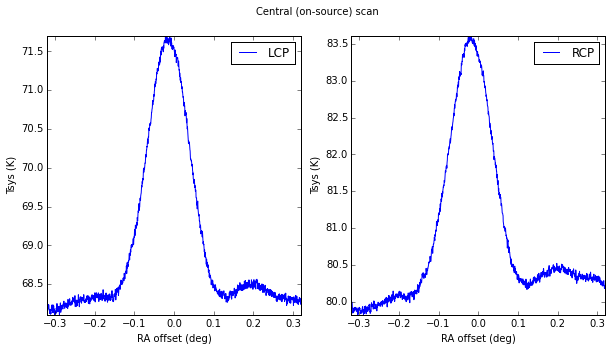

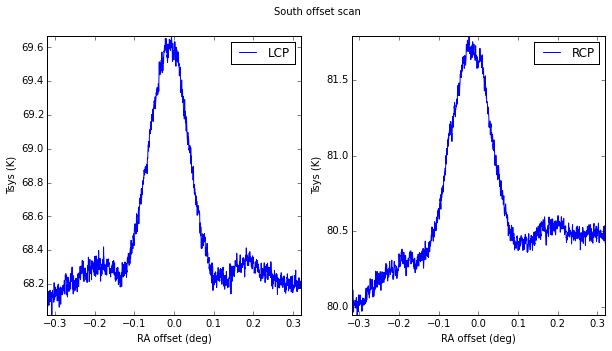

In [29]:
#construct an array for the x-axis in terms of scan offset from the centre
scandist = hdulist[0].header['SCANDIST']
offset = np.linspace(-scandist/2.0, scandist/2.0, len(drift1.data['MJD']))

#extract the scan data, convert to Kelvins and plot
plt.figure(figsize=[10,5])
plt.suptitle('North offset scan')
north_scan_LCP = drift1.data['Count1']/count_K1
north_scan_RCP = drift1.data['Count2']/count_K2
ax = plt.subplot(121)
plt.plot(offset, north_scan_LCP, label = 'LCP')
plt.xlabel('RA offset (deg)')
plt.ylabel('Tsys (K)')
plt.legend()
lim = plt.axis('tight')
ax = plt.subplot(122)
plt.plot(offset, north_scan_RCP, label = 'RCP')
plt.xlabel('RA offset (deg)')
plt.ylabel('Tsys (K)')
plt.legend()
lim = plt.axis('tight')

plt.figure(figsize=[10,5])
plt.suptitle('Central (on-source) scan')
on_scan_LCP = drift2.data['Count1']/count_K1
on_scan_RCP = drift2.data['Count2']/count_K2
ax = plt.subplot(121)
plt.plot(offset, on_scan_LCP, label = 'LCP')
plt.xlabel('RA offset (deg)')
plt.ylabel('Tsys (K)')
plt.legend()
lim = plt.axis('tight')
ax = plt.subplot(122)
plt.plot(offset, on_scan_RCP, label = 'RCP')
plt.xlabel('RA offset (deg)')
plt.ylabel('Tsys (K)')
plt.legend()
lim = plt.axis('tight')

plt.figure(figsize=[10,5])
plt.suptitle('South offset scan')
south_scan_LCP = drift3.data['Count1']/count_K1
south_scan_RCP = drift3.data['Count2']/count_K2
ax = plt.subplot(121)
plt.plot(offset, south_scan_LCP, label = 'LCP')
plt.xlabel('RA offset (deg)')
plt.ylabel('Tsys (K)')
plt.legend()
lim = plt.axis('tight')
ax = plt.subplot(122)
plt.plot(offset, south_scan_RCP, label = 'RCP')
plt.xlabel('RA offset (deg)')
plt.ylabel('Tsys (K)')
plt.legend()
lim = plt.axis('tight')


What can we tell about the telescope by looking at this observation?

The pointing is slightly off. If we had a perfect pointing model, the peak of the scan would always be at 0 RA offset, and the north and south offset scans would have half the power of the central scan. 

The system temperature for the LCP signal chain is about 68 K and for RCP about 80 K.

$T_{sys} = T_{cmb} + T_{gal} + T_{atm} + T_{spill} + T_{sw} + + T_{loss} +  T_{rx}$

where

$T_{cmb}$ ... cosmic microwave background

$T_{gal}$ ... galactic background

$T_{atm}$ ... atmospheric emission

$T_{spill}$ ... ground radiation

$T_{sw}$ ... standing wave pattern

$T_{loss}$ ... ohmic losses, losses in feed

$T_{rx}$ ... receiver noise temperature







## Fit a baseline to remove systemic contributions

We are only interested in the temperature contributed by the source, so we want to subract off the system temperature contribution.  We see that the baseline level changes through during the scan, and the scan also crosses the first sidelobes.  

What do we fit then?  This is a fairly strong source, we can clealy see the antenna beam pattern.  Looking carefully we can see a deflection point at the base of the central Gaussian.  This is the first null of the beam. At these points we will not be receiving any power from the source.

The second table in the fits file gives us useful information on the 4.5cm feed system, including information about the beam.

In [30]:
hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  143 / width of table in bytes                        
NAXIS2  =                    1 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   13 / number of fields in each row                   
EXTNAME = '04.5S   '           / name of this binary table extension            
FEEDTYPE= 'Diagonal'           / Feedtype                                       
BMOFFHA =                -0.46 / Beam offset in HA                              
BMOFFDEC=                 0.02 / Beam offset in Dec                             
HPBW    =                0.1

In [31]:
hpbw = hdulist[1].header['HPBW']    #half power beamwidth
hfnbw = hdulist[1].header['FNBW']/2.0     #half beamwidth to first nulls

In [32]:
from scipy.optimize import curve_fit

def gauss_lin(x, *p):
    """
    Gaussian plus first-order polynomial to fit the telescope beam.
    Note that the width of the Gaussian is hard-coded to the half-power beamwidth
    """
    amp, mu, a, c = p
    sigma = hpbw/(2*np.sqrt(2*np.log(2)))  #a bit messy but not sure how to pass a constant through the curve fitting
    return amp*np.exp(-(x-mu)**2/(2.*sigma**2)) + a*x + c


def fit_drift(offset, drift_power, p0):
    """Fit a Gaussian beam plus first-order polynomial to driftscan and
       plot the results.
    """
    gaus_coeff, var_matrix = curve_fit(gauss_lin, offset, drift_power, p0)
    gauss_fit = gauss_lin(offset, *gaus_coeff)
    plt.plot(offset, drift_power)
    plt.plot(offset, gauss_fit, color='red')
    return gaus_coeff, var_matrix



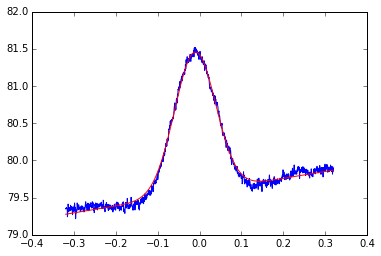

In [33]:
p0 = [3, 0, 0.1, 80]
coeff, covar_matx = fit_drift(offset, north_scan_RCP, p0)

Virgo A is partially resolved by the 26-m telescope, so what we see is not a perfect Gaussian. We don't get a perfect fit, but it can help us disentangle the various components and zoom in on an area in which we can do a  more specialised fit.

We have a good estimate for the baseline, and the centre of the Gaussian.  I plot them below, as well as the centre of the beam and the position of the first nulls to confirm whether the fit works.

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


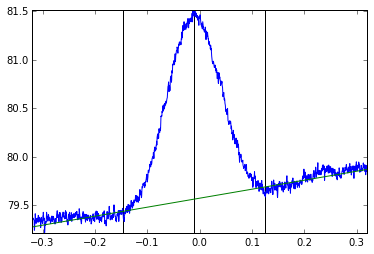

In [34]:
p = np.poly1d([coeff[2], coeff[3]])  #construct a polynomial function from fit results
plt.plot(offset, north_scan_RCP)
plt.plot(offset, p(offset))
lim = plt.axis('tight')
plt.vlines(coeff[1], lim[2], lim[3])
plt.vlines(coeff[1]-hfnbw, lim[2], lim[3])
plt.vlines(coeff[1]+hfnbw, lim[2], lim[3])

Visually, this seems to make sense.  Lets continue

In [35]:
#Get indices where the offset values are within the main beam
main_beam = np.where(np.logical_and(offset >= coeff[1]-hfnbw, offset <= coeff[1]+hfnbw))[0]

I am now going to introduce the concept of masked arrays.  A mask is basically an array of boolean values (0 = False, 1 = True)
Numpy has a module called ma (for masked array).  This module has many of the standard numpy functions, but now with and option to have a mask.  I am going to mask the main beam, then fit a higher order polynomial through the data outside of the main beam.

Masked arrays can also be used to flag RFI.

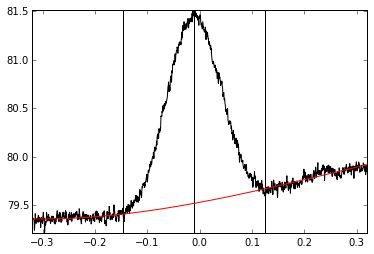

In [36]:
#mask the main beam for polynomial fit to the baseline
mask = np.zeros(len(offset))
mask[main_beam] = 1
offset_masked = np.ma.array(offset,mask=mask)
amp_masked = np.ma.array(north_scan_RCP, mask=mask)

#fit a polynomial of any order
lin_first_null = np.poly1d(np.ma.polyfit(x=offset_masked, y=amp_masked,  deg=3))
plt.plot(offset, north_scan_RCP, color='k')
plt.plot(offset, lin_first_null(offset), color='r')
lim = plt.axis('tight')
plt.vlines(coeff[1], lim[2], lim[3])
plt.vlines(coeff[1]-hfnbw, lim[2], lim[3])
plt.vlines(coeff[1]+hfnbw, lim[2], lim[3])

Subtract the line fit through the first nulls, then try to fit a Gaussian to the main beam data only

In [37]:
def gauss(x, *p):
    """
    Gaussian for fitting the beam 
    """
    amp, mu = p
    sigma = hpbw/(2*np.sqrt(2*np.log(2)))  #a bit messy but not sure how to pass a constant through the curve fitting
    return amp*np.exp(-(x-mu)**2/(2.*sigma**2))
                      
def fit_gauss(offset, drift_power, p0):
    """Fit a Gaussian beam plus first-order
       plot the results.
    """
    gaus_coeff, var_matrix = curve_fit(gauss, offset, drift_power, p0)
    gauss_fit = gauss(offset, *gaus_coeff)
    plt.plot(offset, drift_power)
    plt.plot(offset, gauss_fit)
    return gaus_coeff, var_matrix
                    
                      

Amplitude of peak is 1.95 K


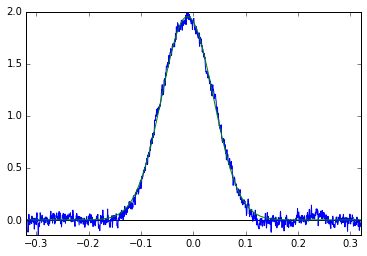

In [38]:
base_sub = north_scan_RCP - lin_first_null(offset)
p0 = [3, 0]
coeff, covar_matx = fit_gauss(offset, base_sub, p0)
lim = plt.axis('tight')
plt.hlines(0, lim[0], lim[1])
print('Amplitude of peak is %.2f K'%coeff[0])

The old data reduction program at HartRAO would fit a 2nd order polynomial through the top of the peak, because the beam isn't really a Gaussian - its actually a modified sin(x)/x function.

However, for the moment, the Gaussian fit seems to work pretty well.

Now that I think I have a strategy that will work, I am going to combine it all into a function.  

Note the text inside the triple quotes.  This is known as a docstring and will be displayed when you ask for inline help.  I came back to this work after a week of doing other stuff, and found I could not remember what all the p0 parameters were because the ordering is quite arbitrary. So writing your documentation as you go along is a really good idea!



In [39]:
def fit_beam(offset, drift_power, p0, hfnbw):
    """
    Fit a Gaussian beam plus linear baseline to driftscan and
    plot the results.
    Use the initial fit to determine the location of the first nulls. 
    Then fit a linear baseline through the first nulls and subtract off.
    Fit a parabola to the top of the main beam to get an accurate fit
    the peak amplitude.
    
    Parameters:
    offset : array of floats, shape (N)
        coordinates in drive (or drift) direction of scan.
    drift_power : array of floats, shape (N)
        measured signal amplitude as a function of offset position
    p0 : array of floats, shape (4)
        initial guess for fitting
        p0[0] = height of Gaussian component
        p0[1] = centre x position of Gaussian component
        p0[2] = slope of linear component
        p0[3] = y-intercept of linear component
    hfnbw : float
        half of beam-width to first nulls
    hhpbw : float
        half of beam-width at half-power point
        
    returns:
    offset : pointing offset in degrees
    peak: peak of Gaussian after baseline subtraction
          
    """
    
    coeff, covar_matrix = curve_fit(gauss_lin, offset, drift_power, p0)
    fit = gauss_lin(offset, *coeff)
    plt.figure(figsize=[10,5])
    ax = plt.subplot(121)
    plt.plot(offset, drift_power)
    plt.plot(offset, fit)
    lim = plt.axis('tight')
    plt.ylabel('Tsys (K)')
    plt.xlabel('Offset from centre (deg)')
    plt.vlines(coeff[1], lim[2], lim[3])
    plt.vlines(coeff[1]-hfnbw, lim[2], lim[3])
    plt.vlines(coeff[1]+hfnbw, lim[2], lim[3])
    
    #Get indices where the offset values are within the main beam
    main_beam = np.where(np.logical_and(offset >= coeff[1]-hfnbw, offset <= coeff[1]+hfnbw))[0]
    
    #Mask the main beam then do a polynomial fit to the baseline outside of the main beam.
    mask = np.zeros(len(offset))
    mask[main_beam] = 1
    offset_masked = np.ma.array(offset,mask=mask)
    amp_masked = np.ma.array(drift_power, mask=mask)
    lin_first_null = np.poly1d(np.ma.polyfit(offset_masked, amp_masked,  3))
    
    #Subtract the polynomial fitted to the baseline, then fit 2nd-order polynomial through the top of the beam.
    base_sub = drift_power - lin_first_null(offset)
    ax = plt.subplot(122)
    
    gauss_p0 = [p0[0], p0[1]] # initial guess for just the Gaussian component
    coeff, covar_matx = fit_gauss(offset, base_sub, gauss_p0)
    lim = plt.axis('tight')
    plt.hlines(0, lim[0], lim[1])
    peak = coeff[0]
    offset = coeff[1]
    print('Amplitude of peak is %.2f K'%coeff[0])
    
    
    return offset, peak
    

Amplitude of peak is 1.95 K


(-0.010999513553385158, 1.9516589740683365)

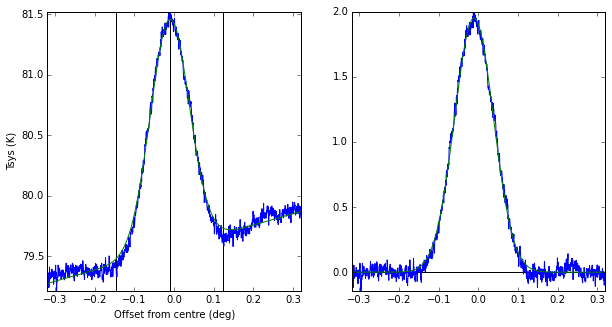

In [40]:
p0 = [3, 0, 0.1, 80]
fit_beam(offset, north_scan_RCP, p0, hfnbw)

Amplitude of peak is 3.36 K


(-0.020095183613374024, 3.3577925558485178)

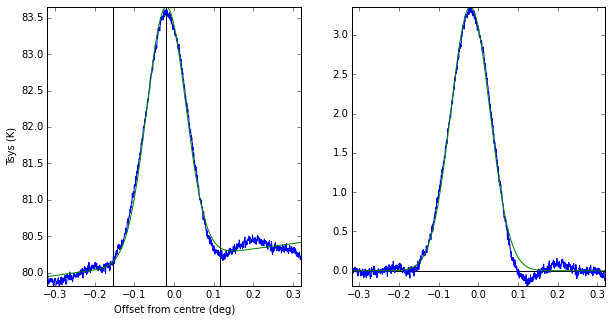

In [41]:
p0 = [3, 0, 0.1, 80]
fit_beam(offset, on_scan_RCP, p0, hfnbw)

## Selection of initial guess

Amplitude of peak is 3.36 K


(-0.020095185150923931, 3.3577925558550494)

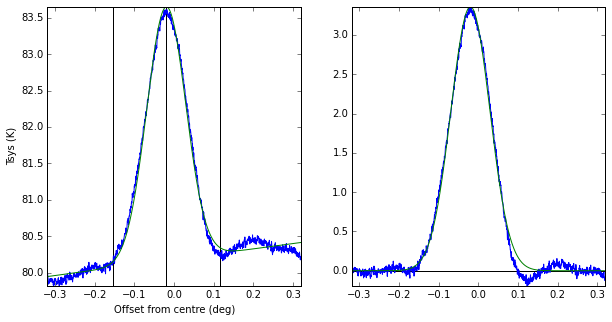

In [42]:
#kick the initial values to see how sensitive the fit is
p0 = [30, 0, 0.1, 800]
fit_beam(offset, on_scan_RCP, p0, hfnbw)

Amplitude of peak is 30.52 K


(0.29250867505951639, 30.518135327637111)

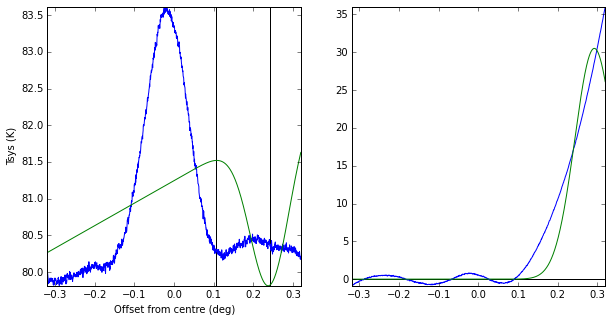

In [43]:
#kick the initial values to see how sensitive the fit is
p0 = [3, 0.2, 0.1, 80]
fit_beam(offset, on_scan_RCP, p0, hfnbw)

Well,that seems reasonable enough - your guess for the linear component can be outrageous and the curve fitter will still converge, but your guess for the centre of the gaussian should be at least somewhere inside the main beam. We are already making the assumption that the first nulls are covered by the scan (ie the pointing model isn't terribly off) and so we are probably ok with assuming that the centre of the source is near the centre of the scan but system temperature can vary considerably so its good that the fit is not sensitive to the guess at the baseline level.

##For discussion

* If you were automating this process, how would you check that the fit was good, and what would you do if it wasn't?
* Is a first-order polynomial fit good enough to correct the baseline drift?  Should we try a higher order in some cases?

##Apply the fit to all the scans
 
We have six scans in total to fit. We then need to calculate a pointing correction in the north-south direction, and apply a correction to the measured 'on-source' amplitude.

We treat each polarisation separately, since they have different gains.

I am going to introduce a new data structure now - the dictionary.  This is a list of key - value pairs.  The fits headers are an example of a dictionary.

##For discussion

Do you think the pointing correction will be different between the  polarisations?  



In [44]:
LCP = {}
#set initial values for the fitting
nom_Tsys = 70 # expected Tsys to set the baseline height
beam_centre = 0 # we're hoping the beam is somewhere close to the centre of the scan
beam_height = 3
slope = 0.1

p0 = [beam_height, beam_centre, slope, nom_Tsys]

Amplitude of peak is 1.97 K
Amplitude of peak is 3.25 K
Amplitude of peak is 1.19 K


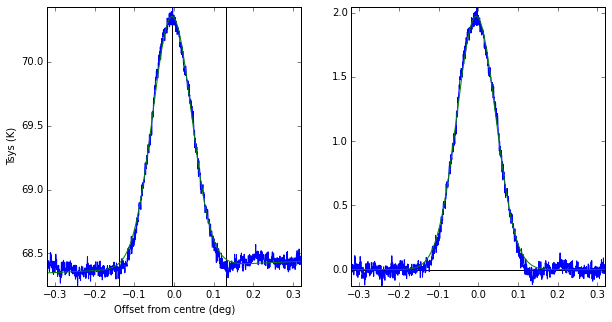

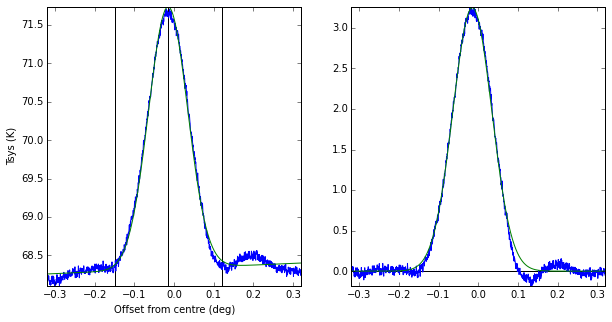

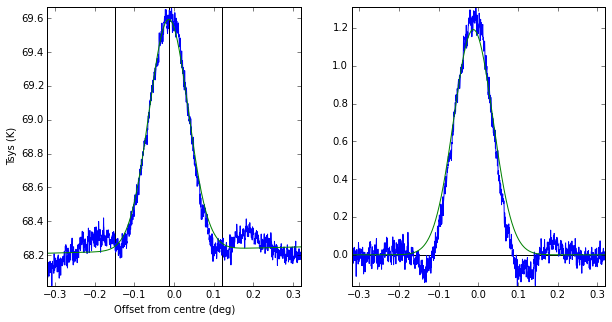

In [45]:
LCP['north_pos'], LCP['north_height'] = fit_beam(offset, north_scan_LCP, p0, hfnbw)
LCP['centre_pos'], LCP['centre_height'] = fit_beam(offset, on_scan_LCP, p0, hfnbw)
LCP['south_pos'], LCP['south_height'] = fit_beam(offset, south_scan_LCP, p0, hfnbw)


In [46]:
print LCP

{'centre_height': 3.248198723781011, 'north_height': 1.9722877109613168, 'south_height': 1.191878746810932, 'centre_pos': -0.014946913255602956, 'north_pos': -0.0050754851934369403, 'south_pos': -0.012771754720146699}


Amplitude of peak is 1.95 K
Amplitude of peak is 3.36 K
Amplitude of peak is 1.22 K


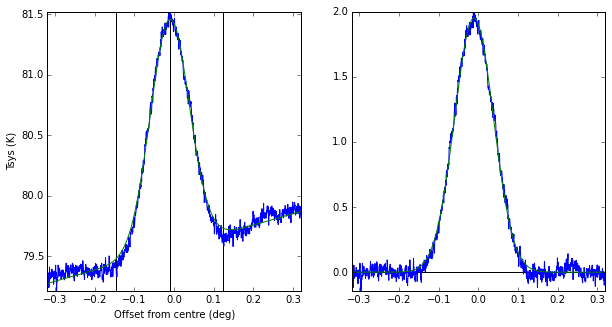

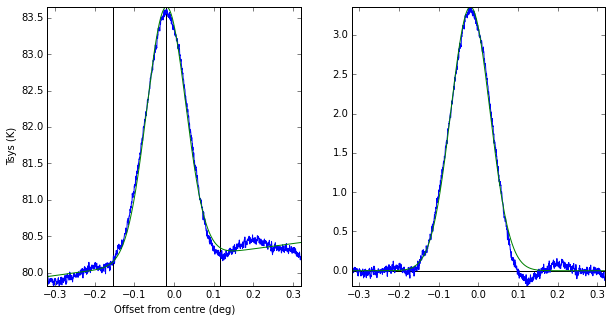

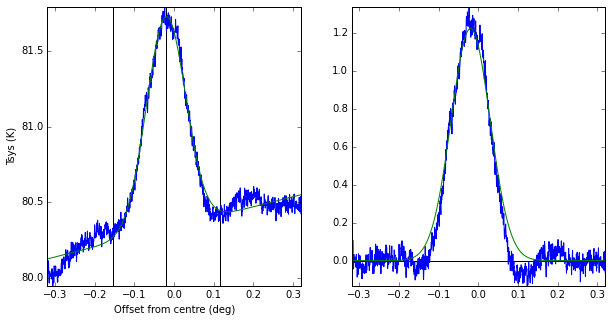

In [47]:
RCP = {}
RCP['north_pos'], RCP['north_height'] = fit_beam(offset, north_scan_RCP, p0, hfnbw)
RCP['centre_pos'], RCP['centre_height'] = fit_beam(offset, on_scan_RCP, p0, hfnbw)
RCP['south_pos'], RCP['south_height'] = fit_beam(offset, south_scan_RCP, p0, hfnbw)


Use a Gaussian approximation to find the pointing offset.  Then calculate a pointing correction to be applied to the peak amplitude.

Amplitude correction factor due to pointing error is 1.020


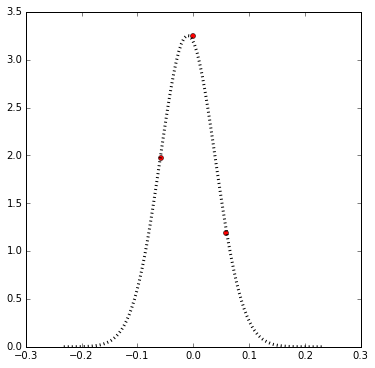

In [48]:
x = [-hpbw/2, 0, hpbw/2]
ns = [LCP['north_height'], LCP['centre_height'], LCP['south_height'] ]
p0 = [LCP['centre_height'], 0.0]
ns_coeff, ns_var_matrix = curve_fit(gauss, x, ns, p0)
pointcor = np.exp(np.log(2) * (ns_coeff[1]**2) / (hpbw/2)**2)
print("Amplitude correction factor due to pointing error is %.3f"%pointcor)
smooth = np.linspace(-2*hpbw, 2*hpbw, 100)
ns_fits = gauss(smooth, *ns_coeff)
plt.figure(figsize=[6,6])
plt.plot(x, ns, 'ro', markersize=5)
plt.plot(smooth, ns_fits, 'k:', linewidth=3)

## For discussion

It is not always possible to get a really good fit to the data points using a Gaussian approximation. Also, the beam isn't really Gaussian past the half-power points. In practise, the method I have shown you only works if the pointing offset is small.  We have found that if the pointing correction is greater than 1.3 (30%) that particular data point in the time-series will exhibit as an outlier.  Throughout most of our monitoring program, the pointing corrections were less than 5%.  However, the telescope's surface was upgraded from perforated aluminium to solid sheets during 2003-2004, and the additional weight changed the telescope's balance, affecting the pointing.

Generally, the telescope control system already applies a pointing model when observing a source.  This pointing model will include factors such as encoder offsets and gravitational deformation. Factors that are dependent only on the telescope's pointing direction are encoded into the model.  Differential heating of the structure during the day can also affect the pointing, but without having a very detailed mechanical model and temperature sensors placed across the structure, we cannot model this.  Hence the calibration that we have just worked through. 

In [49]:
def pointcor(scan, hpbw):
    """
    Calculate a pointing correction factor for continuum driftscans.
    """
    x = [-hpbw/2, 0, +hpbw/2]
    ns = [scan['north_height'], scan['centre_height'], scan['south_height'] ]
    p0 = [scan['centre_height'], 0.0]
    ns_coeff, ns_var_matrix = curve_fit(gauss, x, ns, p0)
    pointcor = np.exp(np.log(2) * (ns_coeff[1]**2) / (hpbw/2)**2)
    print("Amplitude correction factor due to pointing error is %.3f"%pointcor)
    return pointcor
    

In [50]:
RCP['pc'] = pointcor(RCP, hpbw)
LCP['pc'] = pointcor(LCP, hpbw)

Amplitude correction factor due to pointing error is 1.016
Amplitude correction factor due to pointing error is 1.020


In [51]:
#a neater way to view the contents of your dictionary
for key, item in RCP.iteritems():
    print key, item

centre_height 3.35779255585
north_height 1.95165897407
south_height 1.22467709684
centre_pos -0.0200951836134
pc 1.01598997979
north_pos -0.0109995135534
south_pos -0.0196116807345


In [52]:
for key, item in LCP.iteritems():
    print key, item

centre_height 3.24819872378
north_height 1.97228771096
south_height 1.19187874681
centre_pos -0.0149469132556
pc 1.01995003636
north_pos -0.00507548519344
south_pos -0.0127717547201


Dictionaries make very handy containers because you can store pretty much anything in them.  You could also add an array of values to your dictionary - for example the scan data itself, if you didn't want to keep on having to track down each HDU.

In [53]:
LCP['Ta_on_corr'] = LCP['centre_height']*LCP['pc']
RCP['Ta_on_corr'] = RCP['centre_height']*RCP['pc']

# The flux density of the calibrators

For single dish observations, the flux standards defined by Ott et al. (1994) (http://adsabs.harvard.edu/full/1994A&amp;A...284..331O) are still in use (http://adsabs.harvard.edu/abs/1977A%26A....61...99B is an earlier flux scale).  At HartRAO we generally observe three flux calibrators: 3C123, Virgo A and Hydra A.  Most of the sources, with the exception of 3C286 and 3C295 (both too faint to be of much use to us) have shown variability on the time-scale of a decade. So it is generally a good idea to have multiple calibrators.  Three is the minimum number that would enable you to determine which source has undergone intrinsic variation.  

The spectra of the sources are characterised by a frequency dependent expression with three coefficients. 
$$\text{log } S\text{[Jy]} = a + b * \text{log }\nu \text{[MHz]} + c * \text{log}^2 \nu \text{[MHz]}$$

Table 5 of Ott et al. (1994) is shown below:
<img src="files/Ott_Calibrators.png">

In [54]:
def S_ott(a, b, c, nu):
    #evaluate the Ott flux polynomial
    return 10**(a + b * np.log10(nu) + c * np.log10(nu)**2)

In [55]:
nu = drift1.header['CENTFREQ']
VirA = S_ott(4.484, -0.603, -0.0280, nu)
HydA = S_ott(4.728, -1.025, 0.0130, nu)  #3C218 in Ott table
print('Flux density of Virgo A at %.3f MHz is %.2f Jy'%(nu, VirA))
print('Flux density of Hydra A at %.3f MHz is %.2f Jy'%(nu, HydA))

Flux density of Virgo A at 6668.518 MHz is 58.70 Jy
Flux density of Hydra A at 6668.518 MHz is 9.96 Jy


Note that this is the total flux of the source.  Each polarisation of the reciever only picks up half of this flux.

##To do
Write a conditional that checks the source name and calculates the correct flux polynomial

In [56]:
LCP['PSS'] = VirA/(2*LCP['Ta_on_corr'])
RCP['PSS'] = VirA/(2*RCP['Ta_on_corr'])

In [57]:
print('Point source sensitivity of LCP channel is %.2f Jy/K'%LCP['PSS'])
print('Point source sensitivity of RCP channel is %.2f Jy/K'%RCP['PSS'])

Point source sensitivity of LCP channel is 8.86 Jy/K
Point source sensitivity of RCP channel is 8.60 Jy/K


## Note

There is one additional thing we have to correct for if we are using Virgo A as our flux calibrator.  Virgo A at 6.7 GHz is slightly resolved by the 26m telescope. The correction factor is described by Baars (1973, http://adsabs.harvard.edu/abs/1973ITAP...21..461B) and is dependent on the ratio between the angular size of the source and the half-power beam-width of the telescope.


# Exercises

* What is the SEFD of the system?
* What is the aperture efficiency of the telescope?
* Repeat the exercise for an observation taken in early 2003 and then for any observation taken after mid-2005.  What do you find?  Why do you think this has happened?

# Advanced excercise
* Write a dictionary to contain the coefficients for all the calibrators.
* Write a function that will return the flux density of a given calibrator at any frequency in the range covered by the model